In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import string
from pprint import pprint
import unicodedata
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#Setting aesthetics
plt.style.use('seaborn')
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None) # Use this only when needed

In [3]:
#List of General Variables
DATA_FOLDER_PATH = os.path.normpath(r'../data/')
## Normalizing paths
TRAIN_DATA_PATH = os.path.join(DATA_FOLDER_PATH, 'train.csv')
TEST_DATA_PATH = os.path.join(DATA_FOLDER_PATH, 'test.csv')

In [4]:
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

In [5]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# Max no of words in a particular text of the training set
train_list = []
for i in train_data['text']:
    train_list.append(len(i.split()))
    
max(train_list)

31

In [8]:
# Max no of words in a particular text of the test set
test_list = []
for j in test_data['text']:
    test_list.append(len(j.split()))
    
max(test_list)

31

We are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

### Exploration

<strike>We don't need the keyword feature for predictive modelling so we'll delete it from the main training set.</strike>

In [9]:
# Checking Class 1 Head
train_data[train_data.target==1][['id','text','target']].head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,"13,000 people receive #wildfires evacuation orders in California",1
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [10]:
# Checking Class 0 Head
train_data[train_data.target==0][['id','text','target']].head()

,id,text,target
15,23,What's up man?,0
16,24,I love fruits,0
17,25,Summer is lovely,0
18,26,My car is so fast,0
19,28,What a goooooooaaaaaal!!!!!!,0


#### Cheking the data distribution of labels

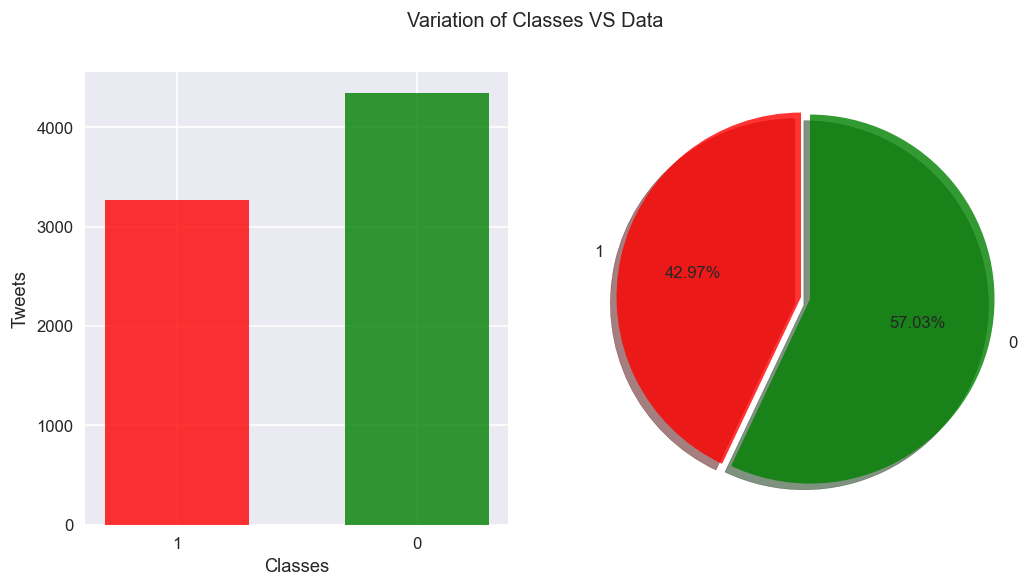

In [11]:
def check_distribution(data):
    targets = np.array(data.target)
    variations = Counter()
    for i in targets:
        variations[str(i)] += 1
        
    variations = dict(variations)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=120)

    ax1.bar(variations.keys(), variations.values(), width=.6, color=['r', 'g'], alpha=0.8)
    ax1.set(xlabel='Classes', ylabel='Tweets')
    ax2.axis('equal')
    
    patches, _, _= ax2.pie(variations.values(),explode=(.05,0), labels=variations.keys(), startangle=90, autopct='%0.2f%%', shadow=True, colors=['r', 'g'])
    for patch in patches:
        patch.set_alpha(0.8)
    ax2.axis('equal')
    plt.suptitle('Variation of Classes VS Data')

    plt.show()
    
check_distribution(train_data)


#### No. of words in a tweet

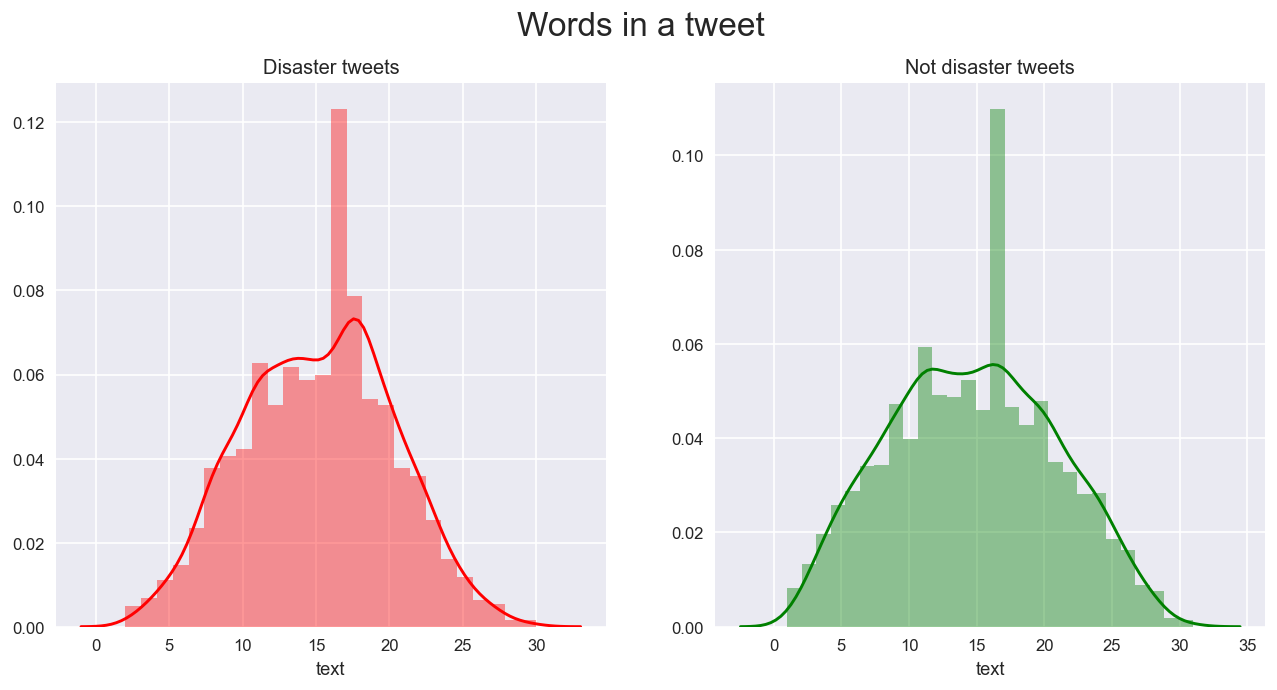

In [12]:
def no_of_words(data):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), dpi=120)
    tweet_len = data[data['target'] == 1]['text'].str.split().map(lambda x: len(x))
    sns.distplot(tweet_len, kde=True, color="r", ax=ax1)
    #ax1.hist(tweet_len,color = 'red')
    ax1.set_title('Disaster tweets')
    tweet_len = data[data['target'] == 0]['text'].str.split().map(lambda x: len(x))
    sns.distplot(tweet_len, kde=True, color="g", ax=ax2)
    ax2.set_title('Not disaster tweets')
    f.suptitle('Words in a tweet', fontsize=20)
    plt.show()

no_of_words(train_data)

#### Common Stopwords in tweets

In [13]:
def create_corpus(target):
    corpus=[]
    
    for x in train_data[train_data['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

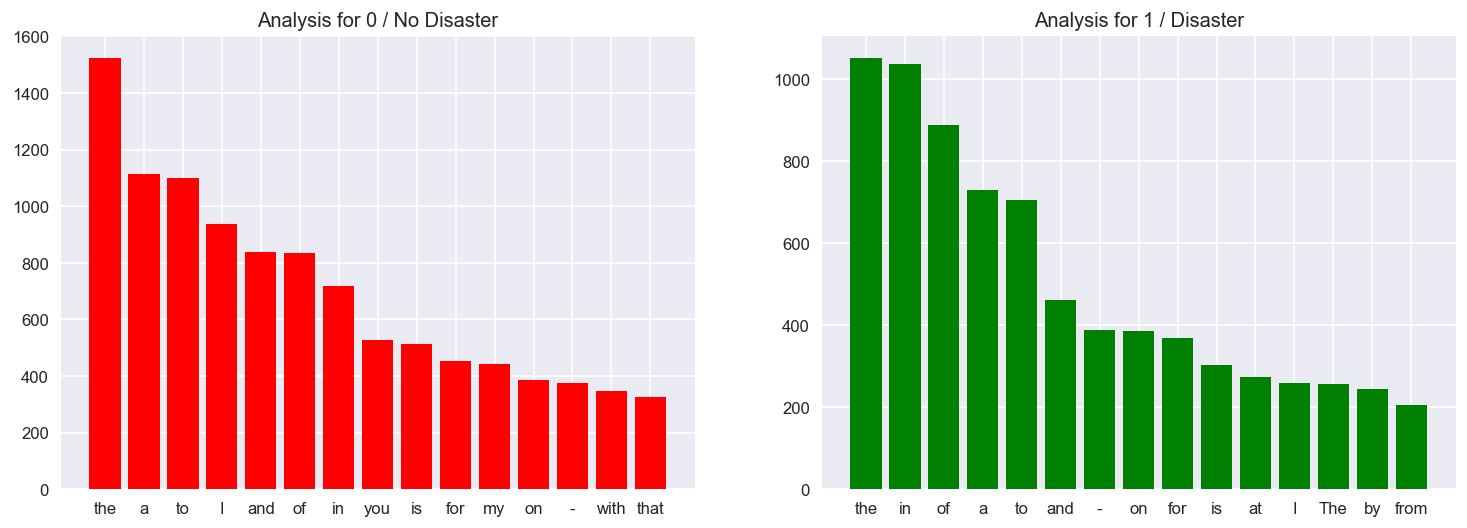

In [14]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5), dpi=120)

# No disaster
not_disaster = create_corpus(0)
counts = Counter(not_disaster).most_common(15) # Selecting 15 most common stopwords
x,y = zip(*counts) 
ax1.bar(x, y, color='red') #sns.barplot() is not working here. 
ax1.set_title('Analysis for 0 / No Disaster')

# Disaster
disaster = create_corpus(1)
counts = Counter(disaster).most_common(15) # Selecting 15 most common stopwords
x,y = zip(*counts) 
ax2.bar(x, y, color='green') #sns.barplot() is not working here. 
ax2.set_title('Analysis for 1 / Disaster')
plt.show()

We find that there are special characters used in tweets as shown above that occur frequently. These characters should be removed before training begins.

#### Analysing special characters

In [15]:
def char_counter(data):
    char_count = Counter()
    for i in list(train_data.text):
        for c in i:
            char_count[c] += 1
    return sorted(char_count.keys())

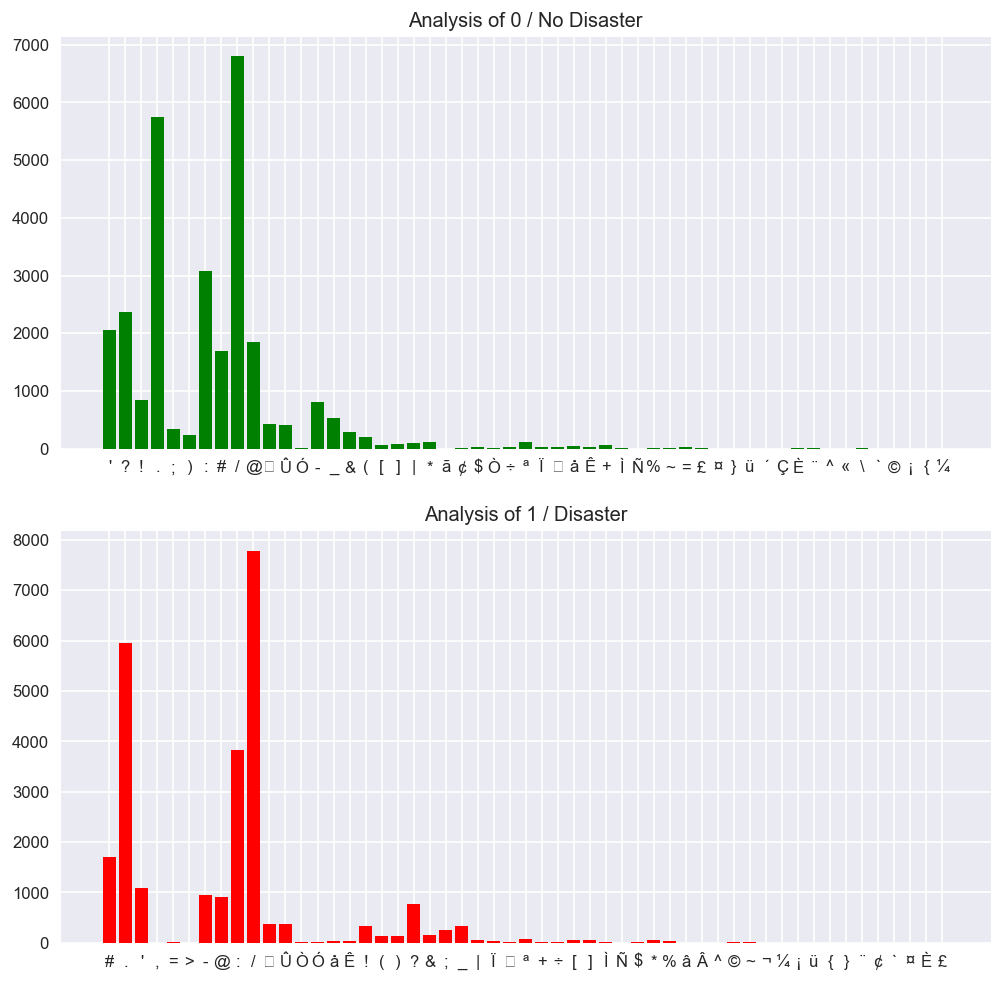

In [16]:
def special_characters_analysis():
    sch = string.punctuation
    s = "".join(char_counter(train_data['text']))
    sch = sch+s[-28:]
    
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,10), dpi=120)
    #fig, ax = plt.subplots(1, 1, figsize=(10,15), dpi=120)
    
    # No disaster
    corpus = create_corpus(0)
    #print(corpus)
    sch_dic = defaultdict(int)
    for i in (corpus):
        for j in i:
            if j in sch:
                sch_dic[j] += 1
    x,y=zip(*sch_dic.items())
    ax1.bar(x,y, color='g')
    ax1.set_title('Analysis of 0 / No Disaster')
    no_dis = sch_dic
    
    # Disaster
    corpus = create_corpus(1)
    sch_dic = defaultdict(int)
    for i in (corpus):
        for j in i:
            if j in sch:
                sch_dic[j] += 1
    x,y=zip(*sch_dic.items())
    ax2.bar(x,y, color='r')
    ax2.set_title('Analysis of 1 / Disaster')
    #dis = sch_dic
    #
    #x = []
    #y1 = []
    #y2 = []
    #for i in sch:
    #    y1.append(no_dis.get(i, 0))
    #    y2.append(dis.get(i, 0))
    #    x.append(i)
    #
    #l = zip(y1,y2,x)
    #l = sorted(list(l))
    #y1, y2, x = zip(*l)
    #
    #y1 = np.array(y1)
    #y2 = np.array(y2)
    #
    #ax.bar(x, y1, facecolor='g', edgecolor='k', label='No Disaster')
    #ax.bar(x, y2, facecolor='r', edgecolor='k', label='Disaster')
    #
    #plt.yticks(fontsize=12)
    #
    #ax.set_title('Special Character Distribution')
    #plt.legend(loc='best')
    plt.show()

special_characters_analysis()

### Data Cleaning

Let's start with cleaning the HTML tags from our data.

<i>// Check 1. The function below should strip all our html tags from our dataset. I urge to check however if this is working in our dataset or not. I tested it on a sample and it's working.</i>

In [17]:
def remove_html(data):
    p = re.compile(r'<.*?>')
    return p.sub(' ', data)

train_data['text'] = train_data['text'].apply(lambda x: remove_html(x))
test_data['text'] = test_data['text'].apply(lambda x: remove_html(x))

Now let's remove all the urls present in the data.

In [18]:
def remove_url(data):
    p = re.compile(r"http\S+")
    return re.sub(p, ' ', data)

train_data['text'] = train_data['text'].apply(lambda x: remove_url(x))
test_data['text'] = test_data['text'].apply(lambda x: remove_url(x))

In tweets people tend to use a lot of emoticons. We have to clean it too.

In [19]:
def remove_emojis(data):
    p = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "]+", flags=re.UNICODE)
    return(p.sub(r' ', data))
    
train_data['text'] = train_data['text'].apply(lambda x: remove_emojis(x))
test_data['text'] = test_data['text'].apply(lambda x: remove_emojis(x))

If you want to view the non-truncated version of this notebook uncomment the second line in the cell where we import the training and the test data i.e. the 4th cell of the notebook.
=> This line: pd.set_option('display.max_rows', None)

Uncomment the line below if you've followed this step.

In [20]:
# train_data

We can see that there is still some data that has to be cleaned such as the hashtags and the tags in the tweets. Also there seems to be some Time data present in the dataset that is yet to be cleaned.

Let's clean all the punctuations.

In [21]:
def remove_social_words(data):
    p = re.compile('[@]\w+')
    return re.sub(p, ' ', data.strip())

train_data['text'] = train_data['text'].apply(lambda x: remove_social_words(x))
test_data['text'] = test_data['text'].apply(lambda x: remove_social_words(x))

In [22]:
def clean_punctuations(data):
    #p = str.maketrans("","",string.punctuation)
    p = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return data.translate(p)

train_data['text'] = train_data['text'].apply(lambda x: clean_punctuations(x))
test_data['text'] = test_data['text'].apply(lambda x: clean_punctuations(x))

In [23]:
def clean_control_characters(data):
    return "".join(ch for ch in data if unicodedata.category(ch)[0]!="C")

train_data['text'] = train_data['text'].apply(lambda x: clean_control_characters(x))
test_data['text'] = test_data['text'].apply(lambda x: clean_control_characters(x))

In [24]:
def clean_unknown_characters(data, extra_characters):
    p = str.maketrans(extra_characters, ' '*len(extra_characters))
    return data.translate(p)

extra_chars = "".join(char_counter(train_data['text'])[63:])

train_data['text'] = train_data['text'].apply(lambda x: clean_unknown_characters(x, extra_chars))
test_data['text'] = test_data['text'].apply(lambda x: clean_unknown_characters(x, extra_chars))

In [25]:
def clean_spaces(data):
    p = re.compile('\s\s+')
    return re.sub(p, ' ', data.strip())

train_data['text'] = train_data['text'].apply(lambda x: clean_spaces(x))
test_data['text'] = test_data['text'].apply(lambda x: clean_spaces(x))

In [26]:
def convert_lower(data):
        return data.lower()
    
train_data['text'] = train_data['text'].apply(lambda x: convert_lower(x))
test_data['text'] = test_data['text'].apply(lambda x: convert_lower(x))

In [27]:
def remove_stopwords(data):
        sw = set(stopwords.words('english'))
        word_tokens = word_tokenize(data)
        filtered_sentence = [w for w in word_tokens if not w in sw]
        return " ".join(filtered_sentence)
    
train_data['text'] = train_data['text'].apply(lambda x: remove_stopwords(x))
test_data['text'] = test_data['text'].apply(lambda x: remove_stopwords(x))

In [28]:
def remove_numbers(data):
    p = str.maketrans("","",'0123456789')
    return data.translate(p)
    
train_data['text'] = train_data['text'].apply(lambda x: remove_numbers(x))
test_data['text'] = test_data['text'].apply(lambda x: remove_numbers(x))

In [29]:
def lemmatize(data):
    tokens = word_tokenize(data)
    return " ".join([WordNetLemmatizer().lemmatize(i) for i in tokens])

train_data['text'] = train_data['text'].apply(lambda x: lemmatize(x))
test_data['text'] = test_data['text'].apply(lambda x: lemmatize(x))

In [30]:
def remove_nouns(data):
    tokens = word_tokenize(data)
    return " ".join([text for text, tag in nltk.tag.pos_tag(tokens) if not tag in ['NNP','NNPS']])

train_data['text'] = train_data['text'].apply(lambda x: remove_nouns(x))
test_data['text'] = test_data['text'].apply(lambda x: remove_nouns(x))

##### The average word length in English language is 4.7 characters. Removing anything double its length

In [31]:
def remove_bigwords(data):
    tokens = word_tokenize(data)
    return " ".join([w for w in tokens if len(w) <= 4.7*2])

#train_data['text'] = train_data['text'].apply(lambda x: remove_bigwords(x))
#test_data['text'] = test_data['text'].apply(lambda x: remove_bigwords(x))

In [32]:
train_data = train_data[['text', 'target']]
train_data.drop_duplicates(inplace=True)

In [33]:
train_data.head()

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer evacuation shelter place order expected,1
3,people receive wildfire evacuation order california,1
4,got sent photo ruby alaska smoke wildfire pours school,1


In [34]:
train_data.to_csv(os.path.join(DATA_FOLDER_PATH, 'clean_train_data_version_003.csv'), index=False)

#### Determining mode for length of word

In [35]:
data_lengths = train_data['text'].str.split().map(lambda x: len(x)).values
print(data_lengths)
stats.mode(data_lengths)

[ 7  7 11 ... 11  9 13]


ModeResult(mode=array([9], dtype=int64), count=array([724]))

#### Determining vocabulary size

In [36]:
vocab = []
for i in list(train_data['text']):
    data = word_tokenize(i)
    vocab += data
vocab = set(vocab)
print(len(vocab))

12802


In [37]:
vocab

{'heal',
 'bred',
 'unimpressed',
 'blooded',
 'centre',
 'monogram',
 'stood',
 'protect',
 'emerges',
 'liverpool',
 'kept',
 'maybe',
 'wdym',
 'okinawa',
 'brick',
 'wrap',
 'crazyideascollege',
 'mattingly',
 'vibrates',
 'government',
 'sue',
 'andre',
 'fixed',
 'yazidi',
 'rascal',
 'sweat',
 'foxsportscom',
 'potus',
 'core',
 'propelled',
 'unfollow',
 'brisbane',
 'lumpur',
 'obedience',
 'indiakomuntorjawabdoindian',
 'holmes',
 'moyo',
 'process',
 'cladding',
 'inhofe',
 'contributor',
 'reckless',
 'alert',
 'brb',
 'magic',
 'saumur',
 'barrier',
 'tower',
 'fluid',
 'bf',
 'criminal',
 'reset',
 'rolo',
 'urogyn',
 'lightly',
 'supernatural',
 'troupe',
 'mumbailocals',
 'burnaby',
 'icarus',
 'splatoon',
 'gauze',
 'iso',
 'estate',
 'donut',
 'park',
 'beclearoncancer',
 'exterminate',
 'mizzou',
 'enjoying',
 'warmth',
 'pop',
 'cartridge',
 'unsurprisingly',
 'fousey',
 'leadership',
 'tangled',
 'kasabwe',
 'sophie',
 'gospel',
 'obliterate',
 'aerospace',
 'dqsvy

In [38]:
vocab_freq = Counter()
for i in list(train_data['text']):
    data = word_tokenize(i)
    for j in data:
        vocab_freq[j] +=1
vocab_freq

Counter({'deed': 2,
         'reason': 27,
         'earthquake': 52,
         'may': 73,
         'allah': 8,
         'forgive': 2,
         'u': 249,
         'forest': 59,
         'fire': 333,
         'near': 54,
         'la': 20,
         'ronge': 1,
         'sask': 1,
         'canada': 13,
         'resident': 8,
         'asked': 9,
         'shelter': 7,
         'place': 30,
         'notified': 1,
         'officer': 32,
         'evacuation': 49,
         'order': 33,
         'expected': 13,
         'people': 182,
         'receive': 2,
         'wildfire': 60,
         'california': 96,
         'got': 125,
         'sent': 13,
         'photo': 55,
         'ruby': 1,
         'alaska': 7,
         'smoke': 49,
         'pours': 1,
         'school': 65,
         'rockyfire': 4,
         'update': 46,
         'hwy': 10,
         'closed': 19,
         'direction': 10,
         'due': 30,
         'lake': 16,
         'county': 37,
         'cafire': 2,
         'fl

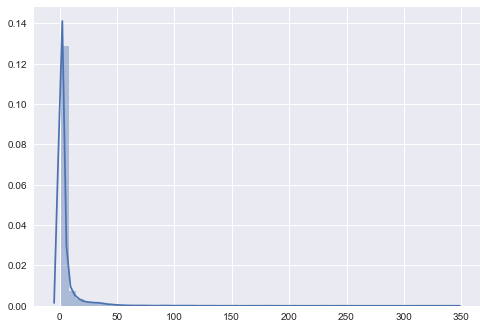

In [56]:
values = list(vocab_freq.values())
sns.distplot(values)
plt.show()

In [39]:
X = train_data['text'].values
y = train_data['target'].values

In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [41]:
for train_ix, test_ix in skf.split(X, y):
    # select rows
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=3240, 1=2256, Test: 0=811, 1=563


#### Vectorization

In [42]:
tokenizer = Tokenizer(num_words=20000, lower=False, split=' ')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

#### Padding

In [43]:
X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test, maxlen=34)

The maximum length for each sequence is 34.